32
1597 None
Bk len is: 1597 32
Bk len is: 1597 32
Bk len is: 1597 32


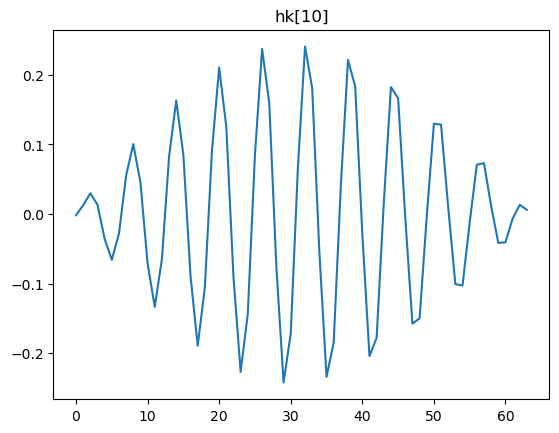

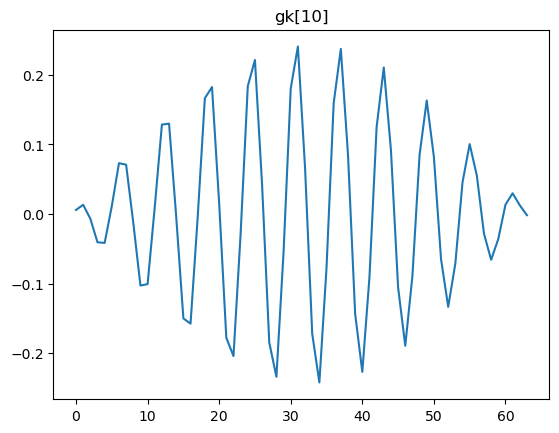

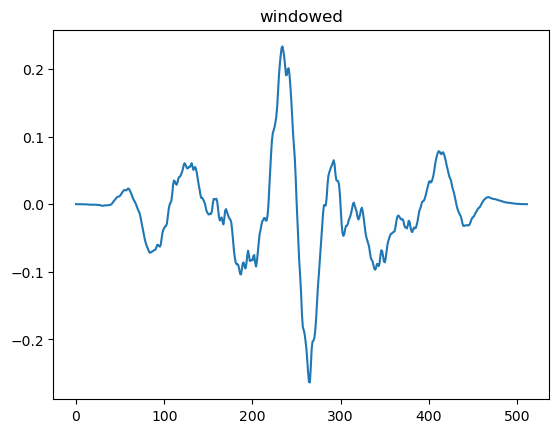

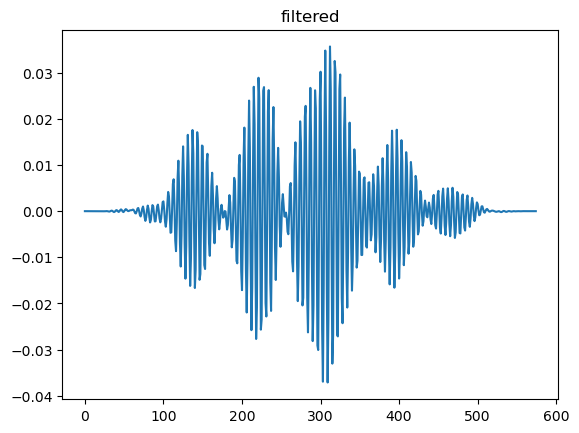

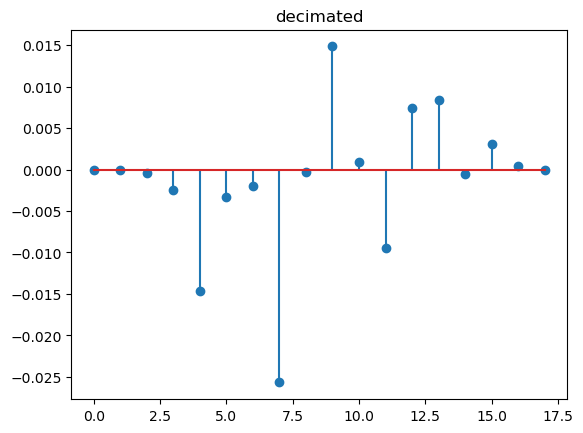

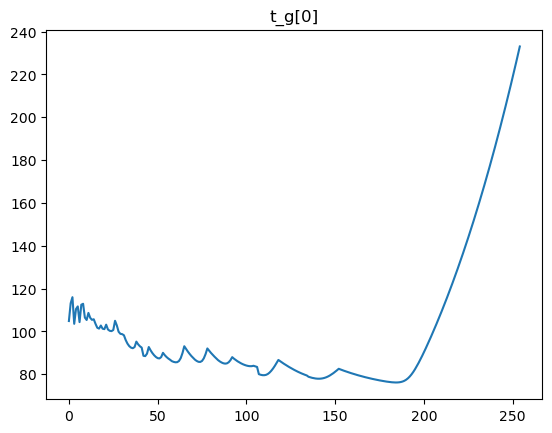

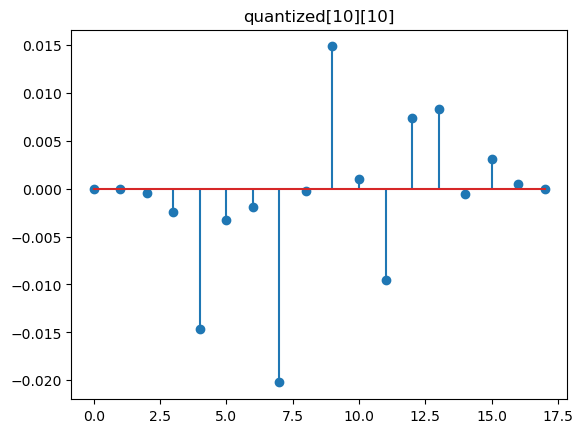

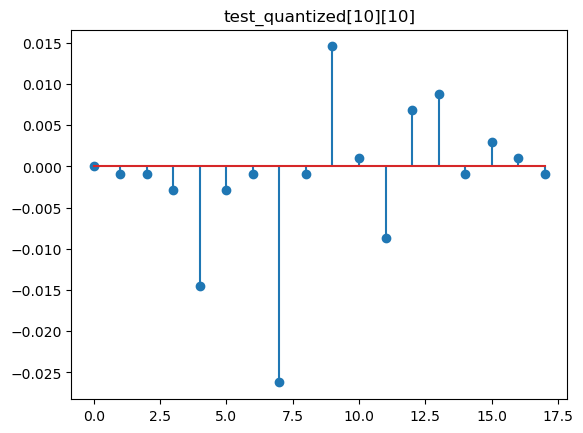

639 639 639 639
817888 32
817889 28


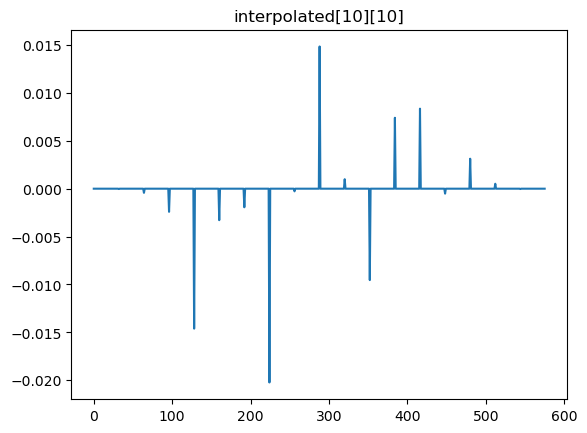

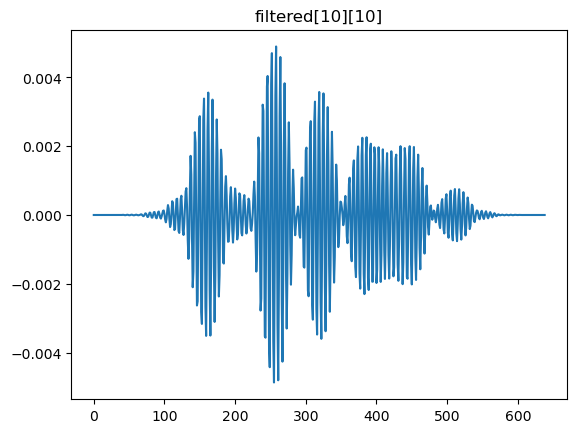

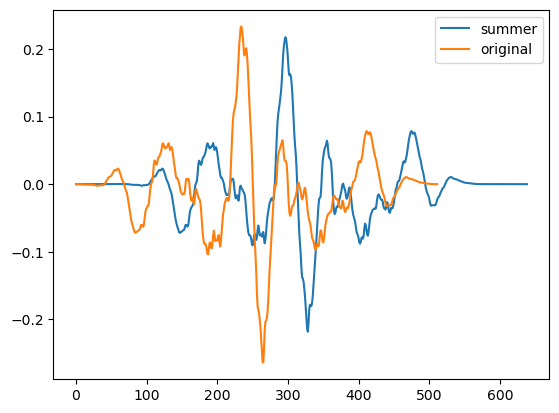

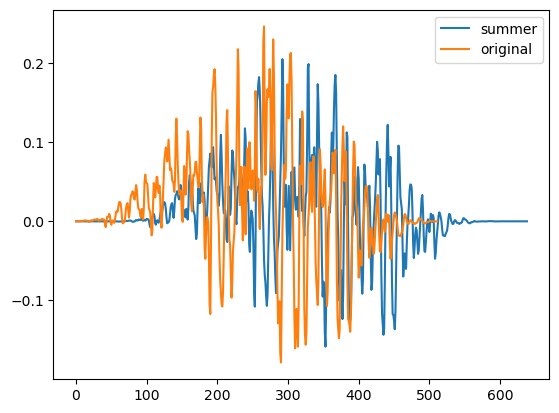

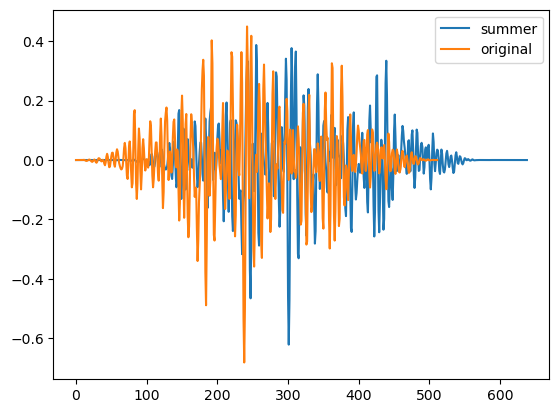

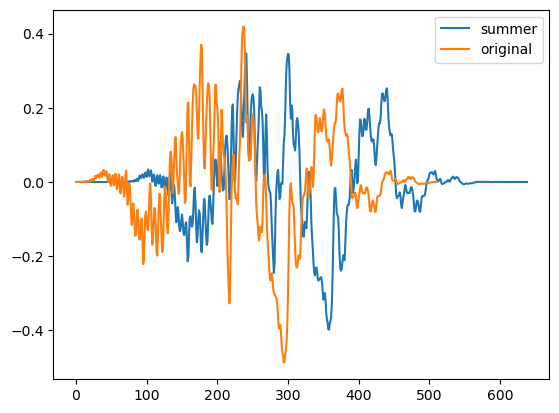

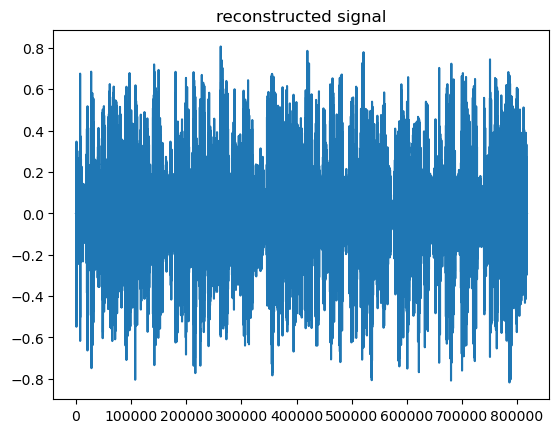

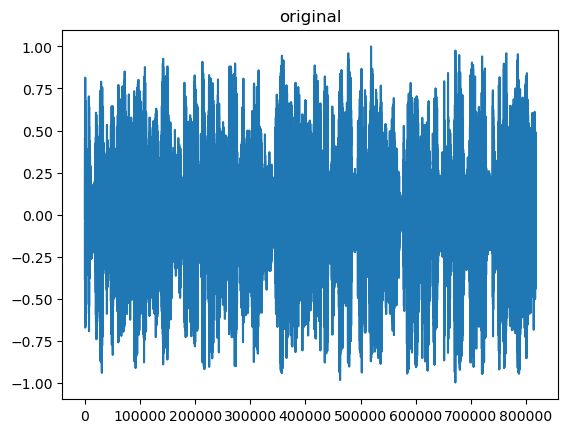

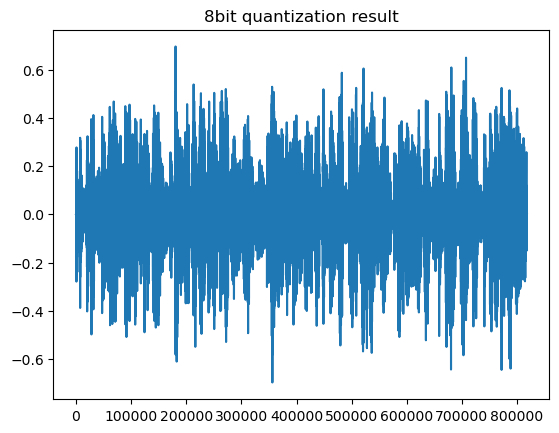

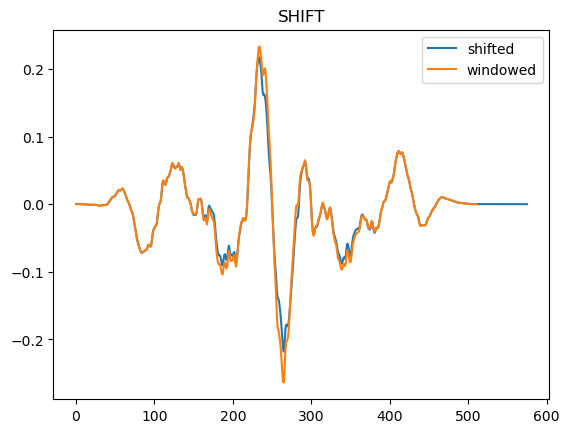

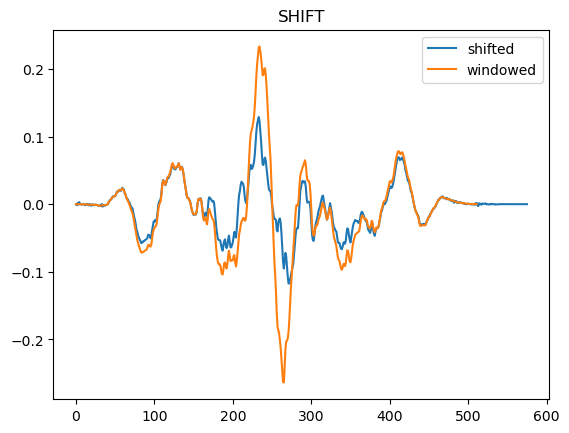

MSE is  0.01870306604927925
Test MSE is  0.026787202717439118
Initial number of bits  13086208
compressed number of bits  8181504
compression(%) =  37.47994835478696


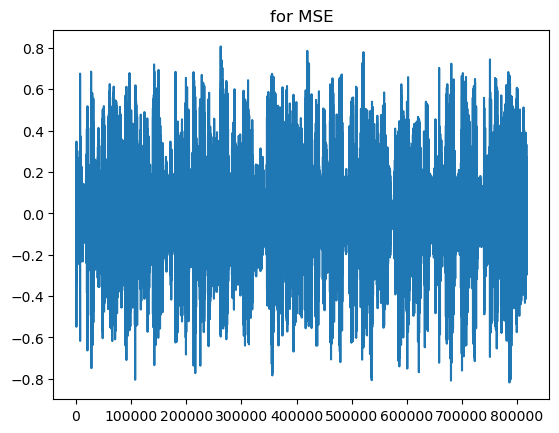

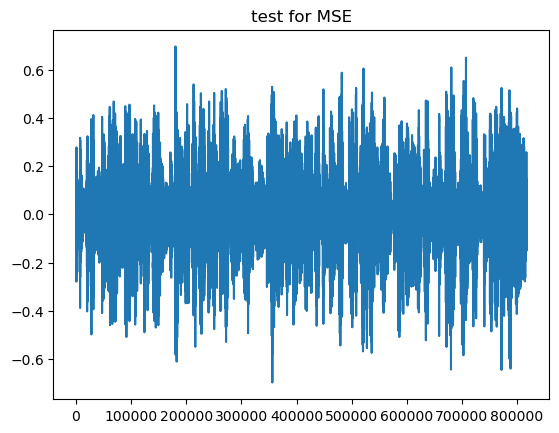

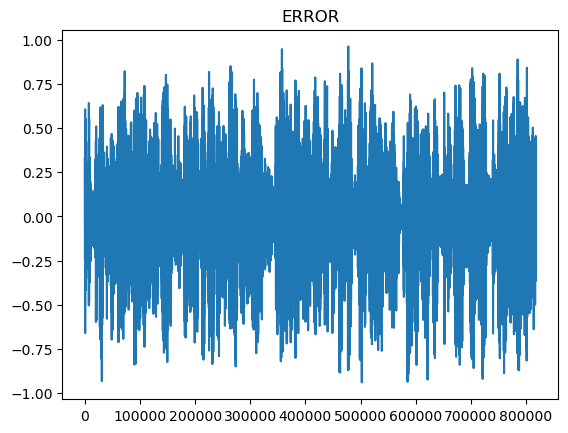

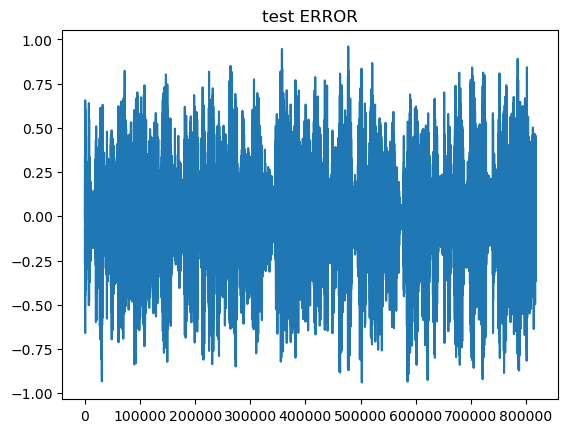

In [2]:
import numpy as np
import matplotlib.pylab as plt
import math
import cmath
from numpy.fft import fft, ifft
from scipy.io.wavfile import read, write
from scipy.signal import spectrogram
import random
import gc
import sys
import os
import sounddevice as sd
from scipy.io.wavfile import read, write
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt
import math
import os
import sounddevice as sd
import sys
from scipy.io.wavfile import read, write


gc.collect()

def convert_to_mono(wav_data):
    if wav_data.ndim == 2:
        return np.mean(wav_data, axis=1)
    return wav_data

def normalize_signal(wav_data):
    max_val = np.max(np.abs(wav_data))
    return wav_data / max_val

def read_wav_file(filename):
    sample_rate, wav_data = wavfile.read(filename)
    mono_data = convert_to_mono(wav_data)
    normalized_data = normalize_signal(mono_data)
    return sample_rate, normalized_data

# Read the audio file from the current working directory
cwd = os.getcwd()
path = os.path.join(cwd, "music.wav")
samplerate, original = read_wav_file(path) 

figure_counter = 0


def window_signal(original, window, length):
    signal = []
    start = 0
    while start + length < len(original):
        temp = []
        for n in range(length):
            temp.append(original[start + n] * window[n])
        signal.append(temp)
        start += length
    return signal


N = 512
window = np.hanning(N)
# window = np.ones(N)
window_signal = window_signal(original, window, N)


def hx(k, M):
    L = 2 * M
    return [np.sin((n + 1 / 2) * math.pi / L) * math.sqrt(2 / M) * np.cos(
        (2 * n + M + 1) * (2 * k + 1) * math.pi / (4 * M)) for n in range(L)]


def gk(hx, k, M):
    L = 2 * M
    return [hx[k][L - 1 - n] for n in range(L)]


M = 32
hk_ = [hx(k, M) for k in range(M)]
gk_ = [gk(hk_, k, M) for k in range(M)]

figure_counter += 1
plt.figure(figure_counter)
plt.title("hk[10]")
plt.plot(hk_[10])

figure_counter += 1
plt.figure(figure_counter)
plt.title("gk[10]")
plt.plot(gk_[10])


# Convolve the windowed signal with the analysis filters
filtered_signal = [[np.convolve(hk_[k], np.array(window_signal[i]).flatten()) for k in range(M)] for i in range(len(window_signal))]


figure_counter += 1
plt.figure(figure_counter)
plt.title("windowed")
plt.plot(window_signal[10])

figure_counter += 1
plt.figure(figure_counter)
plt.title("filtered")
plt.plot(filtered_signal[10][10])

# Play the audio
sd.play(original, samplerate)

# Rest of the code remains the same


def decimate(signal, factor):
    temp = []
    for i in range(len(signal)):
        if i % factor == 0:
            temp.append(signal[i])
    return temp


decimated_filtered_signal = [[decimate(filtered_signal[i][k], M) for k in range(M)] for i in range(len(window_signal))]

figure_counter += 1
plt.figure(figure_counter)
plt.title("decimated")
plt.stem(decimated_filtered_signal[10][10])


T_g = np.load("T_g_i.npy")
figure_counter += 1
plt.figure(figure_counter)
plt.title("t_g[0]")
plt.plot(T_g[0])


L = 2 * M


def f(k):
    return ((2 * k - 1) * samplerate * math.pi / (L) - samplerate * math.pi / (L),
            (2 * k - 1) * samplerate * math.pi / (L) + samplerate * math.pi / (L))


R = 2 ** 16


def newTg(k, T_g):
    f_ = f(k)
    # print(f_, i, k)
    temp = []
    for i in range(len(T_g)):
        f_i = samplerate * 2 * math.pi * i / N
        if f_[0] <= f_i <= f_[1]:
            temp.append(T_g[i])
    return (R / min(temp))


Bk = [[math.ceil(np.log2(newTg(k, T_g[i])) - 1) for k in range(1, M + 1)] for i in range(len(window_signal))]

delta = []

print(len(decimated_filtered_signal), print(len(decimated_filtered_signal[0])))

for i in range(len(decimated_filtered_signal)):
    temp = []
    min_temp = []
    for k in range(M):
        range_ = max(decimated_filtered_signal[i][k]) - min(decimated_filtered_signal[i][k])
        # non = np.array(window_signal[i])
        # range_ = 2*max(np.abs(non))
        temp.append(range_ / (math.pow(2, Bk[i][k])))
    delta.append(temp)



def quantization(x, Delta_s, b):
    newSig = []

    for i in range(len(x)):
        bool = 0
        for k in range(2 ** (b - 1)):
            if k * Delta_s <= abs(x[i]) <= (k + 1) * Delta_s:
                if x[i] > 0:
                    newSig.append((0.5 + k) * Delta_s)
                elif x[i] < 0:
                    newSig.append((-0.5 - k) * Delta_s)
                else:
                    newSig.append(0.0)
                bool = 1
                break
        if bool == 0:
            if x[i] >= 0:
                newSig.append((2 ** (b - 1) - 0.5) * Delta_s)
            else:
                newSig.append(-(2 ** (b - 1) - 0.5) * Delta_s)
    return newSig


print("Bk len is:", len(Bk), len(Bk[0]))
print("Bk len is:", len(decimated_filtered_signal), len(decimated_filtered_signal[0]))
print("Bk len is:", len(delta), len(delta[0]))

quantized_signal = [[quantization(decimated_filtered_signal[i][k], delta[i][k], Bk[i][k])
                     for k in range(len(decimated_filtered_signal[i]))]

                    for i in range(len(decimated_filtered_signal))]

figure_counter += 1
plt.figure(figure_counter)
plt.title('quantized[10][10]')
plt.stem(quantized_signal[10][10])



test_Bk = 8
original = list(original)

def max_of_seg(seg):
    maxx = 0
    for k in seg:
        if maxx < max(k):
            maxx = max(k)
    return maxx

def min_of_seg(seg):
    minn = 0
    for k in seg:
        if minn > min(k):
            minn = min(k)
    return minn


# test_delta = (max(original) - min(original))/(2**test_Bk)
test_quantized = []
for i in range(len(decimated_filtered_signal)):
    temp = []
    test_delta = (np.max(window_signal[i]) - np.min(window_signal[i])) / (2 ** test_Bk)
    # test_delta = (max_of_seg(decimated_filtered_signal[i]) - min_of_seg(decimated_filtered_signal[i]))/(2**test_Bk)
    # test_delta = max(decimated_filtered_signal[i][k]) - min(decimated_filtered_signal[i][k])
    # print(len(decimated_filtered_signal[i]), i)
    for k in range(len(decimated_filtered_signal[i])):
        # if i == 10 and k == 10:
            # print(test_delta)
        temp.append(quantization(decimated_filtered_signal[i][k], test_delta, test_Bk))

    test_quantized.append(temp)

figure_counter += 1
plt.figure(figure_counter)
plt.title("test_quantized[10][10]")
plt.stem(test_quantized[10][10])

plt.show()

interpolated = []

for q in quantized_signal:
    temp2 = []
    for k in q:
        temp = []
        for l in k:
            temp.append(l)
            for m in range(M - 1):
                temp.append(0)

        temp2.append(temp)

    interpolated.append(temp2)


figure_counter += 1
plt.figure(figure_counter)
plt.title("interpolated[10][10]")
plt.plot(interpolated[10][10])



last_filtered_signal = [[np.convolve(interpolated[i][k], gk_[k]) for k in range(len(interpolated[i]))]
                        for i in range(len(interpolated))]



figure_counter += 1
plt.figure(figure_counter)
plt.title("filtered[10][10]")
plt.plot(last_filtered_signal[10][10])


summer = []

for l in last_filtered_signal:
    temp = []
    for k in l:
        for n, c in enumerate(k):
            if n >= len(temp):
                temp.append(0)  # Add elements to the list if the index is out of bounds
            temp[n] += c
    summer.append(temp)


    
figure_counter += 1
plt.figure(figure_counter)
plt.plot(summer[10], label="summer")
plt.plot(window_signal[10], label="original")
plt.legend()

figure_counter += 1
plt.figure(figure_counter)
plt.plot(summer[50], label="summer")
plt.plot(window_signal[50], label="original")
plt.legend()



figure_counter += 1
plt.figure(figure_counter)
plt.plot(summer[356], label="summer")
plt.plot(window_signal[356], label="original")
plt.legend()


figure_counter += 1
plt.figure(figure_counter)
plt.plot(summer[251], label="summer")
plt.plot(window_signal[251], label="original")
plt.legend()



def overlap(my_list, length, tot_length, seg_length):
    start = 0
    temp = [0] * (tot_length + 1)  # Initialize temp with a larger size

    for l in my_list:
        if start >= tot_length - seg_length:
            return temp
        for i in range(length):
            if start + i > tot_length:
                break
            temp[start + i] += l[i]

        start += seg_length
    return temp


print(len(summer[0]), len(summer[500]), len(summer[1000]), len(summer[1100]))
sum_overlap_add = overlap(summer, len(summer[0]), len(original), N)

figure_counter += 1
plt.figure(figure_counter)
plt.title("reconstructed signal")
plt.plot(sum_overlap_add)

figure_counter += 1
plt.figure(figure_counter)
plt.title("original")
plt.plot(original)

sum_overlap_add = np.array(sum_overlap_add, dtype=np.float32)
write("output.wav", samplerate, np.array(sum_overlap_add, dtype=np.float32))

print(len(original), sys.getsizeof(original[0]))
print(len(sum_overlap_add), sys.getsizeof(sum_overlap_add[0]))


# Play the reconstructed signal
sd.play(sum_overlap_add, samplerate)
sd.wait()


test_interpolated = []
for q in test_quantized:
    temp2 = []
    for k in q:
        temp = []
        for l in k:
            temp.append(l)
            for m in range(M - 1):
                temp.append(0)

        temp2.append(temp)

    test_interpolated.append(temp2)

test_last_filtered_signal = [[np.convolve(test_interpolated[i][k], gk_[k]) for k in range(len(test_interpolated[i]))]
                             for i in range(len(interpolated))]

test_summer = []

for l in test_last_filtered_signal:
    temp = np.zeros(639)
    for k in l:
        for n, c in enumerate(k):
            temp[n] += c

    test_summer.append(list(temp))

test_sum_overlap_add = overlap(test_summer, len(test_summer[0]), len(original), N)

test_sum_overlap_add = np.array(test_sum_overlap_add, dtype=np.float32)
write("output_8bit.wav", samplerate, np.array(test_sum_overlap_add, dtype=np.float32))

# Play the test reconstructed signal
sd.play(test_sum_overlap_add, samplerate)
sd.wait()

figure_counter += 1
plt.figure(figure_counter)
plt.title("8bit quantization result")
plt.plot(test_sum_overlap_add)


plt.show()


def shifting(signal, factor):
    return signal[factor:]


def calculate_factor(signal, recon):
    return recon.index(max(recon)) - signal.index(max(signal))


sum_overlap_add = list(sum_overlap_add)
window_signal = list(window_signal)

shifted = [shifting(summer[i], 63) for i in range(len(summer))]
test_shifted = [shifting(test_summer[i], 63) for i in range(len(test_summer))]

figure_counter += 1
plt.figure(figure_counter)
plt.title("SHIFT")
plt.plot(shifted[10], label="shifted")
plt.plot(window_signal[10], label="windowed")
plt.legend()


figure_counter += 1
plt.figure(figure_counter)
plt.title("SHIFT")
plt.plot(test_shifted[10], label="shifted")
plt.plot(window_signal[10], label="windowed")
plt.legend()



plt.show()


for_MSE = overlap(shifted, len(shifted[0]), len(original), N)
test_for_MSE = overlap(test_shifted, len(test_shifted[0]), len(original), N)

figure_counter += 1
plt.figure(figure_counter)
plt.title("for MSE")
plt.plot(for_MSE)

figure_counter += 1
plt.figure(figure_counter)
plt.title("test for MSE")
plt.plot(test_for_MSE)



def MSE(signal, recon):
    return np.mean(np.array([(signal[i] - recon[i])**2 for i in range(min(len(signal), len(recon)))]))


def calculate_error(signal, recon):
    return [signal[i] - recon[i] for i in range(min(len(signal), len(recon)))]

error = calculate_error(original, for_MSE)
test_error = calculate_error(original, test_for_MSE)

figure_counter += 1
plt.figure(figure_counter)
plt.title("ERROR")
plt.plot(error)

figure_counter += 1
plt.figure(figure_counter)
plt.title("test ERROR")
plt.plot(test_error)

print("MSE is ", MSE(original, for_MSE))
print("Test MSE is ", MSE(original, test_for_MSE))


initial_number_of_bits = 16 * len(original)

compress_bits = 0
for i in range(len(Bk)):
    for k in range(M):
        compress_bits += Bk[i][k] * 18

print("Initial number of bits ", initial_number_of_bits)
print("compressed number of bits ", compress_bits)
print("compression(%) = ", ((initial_number_of_bits - compress_bits)/initial_number_of_bits)*100)

plt.show()